In [1]:
from math import sqrt
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import glob
import seaborn as sns
sns.set()
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

## Import of the previously extracted transactions

In [2]:
data = pd.read_csv('bloxberg.csv')

In [3]:
data

,Unnamed: 0,timestamp,blocknumber,to,from,gas,gasPrice,nonce,value
0,0,1547107485,33,NaN,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,889637,0,0,0
1,1,1547107625,61,NaN,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,1952182,0,1,0
2,2,1547107680,72,0x9850711951A84Ef8a2A31a7868d0dCa34B0661cA,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,45333,0,2,0
3,3,1547111675,845,0x9849379b89aB24c18C8871d56d1Ad41E00d9eAae,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,1000000,50000000000,3,0
4,4,1547111745,859,0x9849379b89aB24c18C8871d56d1Ad41E00d9eAae,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,1000000,50000000000,4,0
...,...,...,...,...,...,...,...,...,...
9527281,9527281,1597489805,7535649,0xD216153c06E857cD7f72665E0aF1d7D82172F494,0x4eD1cA7563Ae29FE02d278a3fEE4876C9BA317d3,52216,1000000,13721,0
9527282,9527282,1597490350,7535715,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,53651,200000000000000000
9527283,9527283,1597490365,7535717,0xD216153c06E857cD7f72665E0aF1d7D82172F494,0x4eD1cA7563Ae29FE02d278a3fEE4876C9BA317d3,52276,1000000,13722,0
9527284,9527284,1597490410,7535721,0xD216153c06E857cD7f72665E0aF1d7D82172F494,0x4eD1cA7563Ae29FE02d278a3fEE4876C9BA317d3,52216,1000000,13723,0


In [23]:
first_transaction_timestamp = data['timestamp'].min()
last_transaction_timestamp = data['timestamp'].max()





## Filtering and Cleanup

Filter the data and exclude noise, such that only faucet transactions are left.
Faucet transactions are defined by those transactions from the faucet adress to an adress that is not acting as custodial wallet for a bloxberg service.


In [4]:
faucet_adress = '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088'
certify_research_data_sc_adress = '0xE5a9654C7e190701016EBf18206020bf16D8Beab'

gas_used_ether_tx = 30000 # plain ether transaction will have this gas usage

all_faucet_tx = data[(data['from'] == faucet_adress) & (data['gas'] == gas_used_ether_tx)]
all_faucet_tx

,Unnamed: 0,timestamp,blocknumber,to,from,gas,gasPrice,nonce,value
15,15,1547112880,1071,0xD748BF41264b906093460923169643f45BDbC32e,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,15,500000000000000000
75,75,1547553475,89190,0xf9f4EF25373E0dabdd80eed7299Fd5234F7D4d89,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,69,500000000000000000
76,76,1547553500,89195,0xf9f4EF25373E0dabdd80eed7299Fd5234F7D4d89,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,70,500000000000000000
187,187,1548080680,194631,0xb0Eef975F568A6CDce67E156113629CB2791cf3b,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,167,500000000000000000
188,188,1548080710,194637,0xb0Eef975F568A6CDce67E156113629CB2791cf3b,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,168,500000000000000000
...,...,...,...,...,...,...,...,...,...
9525510,9525510,1597382845,7522755,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,53530,200000000000000000
9525639,9525639,1597400805,7524898,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,53551,200000000000000000
9525717,9525717,1597412135,7526248,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,53563,200000000000000000
9527196,9527196,1597470890,7533360,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,53629,200000000000000000


## General Overview

In [5]:
tx_per_address = all_faucet_tx['to'].value_counts()
display("Total number of addresses receiving tx from faucet: {}".format(tx_per_address.size))

'Total number of addresses receiving tx from faucet: 235'

In [6]:
many_tx = 10
adresses_with_many_tx = tx_per_address[tx_per_address > many_tx]
a_with_many_tx_perc = adresses_with_many_tx.size / tx_per_address.size * 100

adresses_with_single_tx = tx_per_address[tx_per_address == 1] 
a_with_single_tx_perc = adresses_with_single_tx.size / tx_per_address.size * 100

display("Percentage of accounts with a single receiving transaction: {}".format(a_with_single_tx_perc))
display("Percentage of accounts with many transctions (with many being considered more than {}): {}".format(many_tx, a_with_many_tx_perc))


'Percentage of accounts with a single receiving transaction: 38.297872340425535'

'Percentage of accounts with many transctions (with many being considered more than 10): 19.574468085106382'

In [7]:
adresses_with_many_tx.to_csv('suspicious_addresses.csv')

[(0.0, 50.0), (0.0, 30.0)]

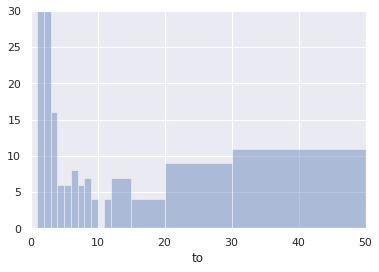

In [55]:
ax = sns.distplot(tx_per_address, kde=False, bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 50])

ax.set(xlim=(0, 50), ylim=(0, 30))
# sns.plot.ylim(0, 20)


<AxesSubplot:xlabel='to'>

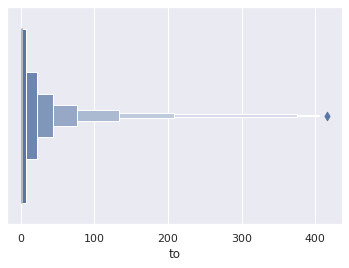

In [22]:
boxen_plot = sns.boxenplot(tx_per_address)
boxen_plot.figure.savefig('boxen.png')
boxen_plot

<AxesSubplot:title={'center':'Distribution of faucet transaction count for single adress for count > 10'}, xlabel='to'>

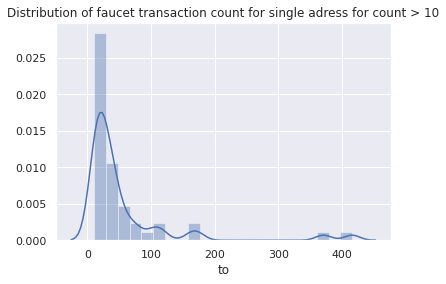

In [21]:
dist_plot = sns.distplot(adresses_with_many_tx)
dist_plot.set_title('Distribution of faucet transaction count for single adress for count > {}'.format(many_tx))
dist_plot.figure.savefig('dist.png')

dist_plot

## Calculate Stats for Addresses

In [69]:
f = data['from']
t = data['to']

all_addresses = pd.concat([f, t]).unique()

array(['0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088',
       '0xD748BF41264b906093460923169643f45BDbC32e',
       '0xf9f4EF25373E0dabdd80eed7299Fd5234F7D4d89', ...,
       '0x539567026E0aA9BB3178e4C2bf7994FCc5617548',
       '0xe30ba6eD8D41165D240abA5052609569BC68a8dC',
       '0x6ceA323C21BBDd22526297F4Bcc73BA637f9997E'], dtype=object)

In [15]:
def count_unique_interactions(a):
    to_targets = data[data['from'] == a] # this queries could be joined, but then we would need to filter out a from the results
    from_targets = data[data['to'] == a]

    number_tx = len(to_targets.index) + len(from_targets.index)

    # Not working trivially because of possible NaN values
    #first_transaction = min(to_targets['timestamp'].min(), from_targets['timestamp'].min())
    #last_transaction = max(to_targets['timestamp'].max(), from_targets['timestamp'].max())

    unique_to_cnt = len(to_targets['to'].unique())
    unique_from_cnt = len(from_targets['from'].unique())

    return [a, unique_to_cnt, unique_from_cnt, unique_to_cnt + unique_from_cnt, number_tx]

In [99]:
interactions_per_address = [count_unique_interactions(a) for idx, a in tqdm(np.ndenumerate(all_addresses), total=len(all_addresses))]
df_interactions = pd.DataFrame(interactions_per_address, columns=['address', 'unique_to', 'unique_from', 'unique_sum', 'cnt_tx'])
df_interactions.to_csv('account_interaction_counts.csv')
df_interactions

,address,unique_to,unique_from,unique_sum,cnt_tx
0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,251,0,251,53653
1,0xD748BF41264b906093460923169643f45BDbC32e,90,2,92,559
2,0xf9f4EF25373E0dabdd80eed7299Fd5234F7D4d89,1,1,2,3
3,0xf83F0DAe831B9323850b8149cd46AF48d8b996a1,3,1,4,6
4,0x814b1b9d07C3b471DbF6E8b8BAc91954921aEc64,2,1,3,4
...,...,...,...,...,...
1307,0x95Ae66C2413033556c67eC3fCDc7f01a2fF5D385,0,2,2,8
1308,0xC5B3B9b457233f912bE52345e4E02286A9bEbb1e,0,3,3,6
1309,0x539567026E0aA9BB3178e4C2bf7994FCc5617548,0,143,143,146
1310,0xe30ba6eD8D41165D240abA5052609569BC68a8dC,0,144,144,153


In [12]:
for i in adresses_with_many_tx.index:
    print(i)

0x2CedAee1c717535BBDDacAB27A56FF81ffDA2a78
0x7b0bfA9F3fd91cB111a82c691971E1BABe8b72d6
0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00
0x01b7492A43416eD673a75A1BF5602312e25C7D24
0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44
0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E
0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0
0xB364dB24A41D807Ad12A37506bD79CF2A397E643
0x15433DA387451F9dE4565280C85506CB71aF9376
0xf17f52151EbEF6C7334FAD080c5704D77216b732
0x737756B173D2F41D63a46Ed6094DAF7E8a78F997
0x3253Bf11fb207543f6aF73bBC8625775d22aB8DE
0x68bc4ea819f98201E897EC8306897FD3FF64A5a3
0x094191169aac3413BD1d91B6a84309021b217439
0x7FEb55AD745CcbDfc028b2bBDB211a6256163dE4
0xaEc7be3Ca0fF850CB03A39D7A8f3ee62e4F15E65
0xA73Af2d1bd6809cD8002a6DB230C32e31992FA8C
0x5e923C02Eeb0730eb4CB5EDb6708651B5a47529D
0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C
0x2A0b58ae4347D87B1C7CD6FEB2e3A654B69655DD
0xABBCb53BAfC0226C9C11D847CfD75400A9870551
0x234c38746459Eca01804F2207B0E5627225F4dcE
0xB0542eA802964A10271EB7cbA6105c96Eac82aD7
0xc8afe02B1

In [16]:
interactions_per_susp_address = [count_unique_interactions(a) for a in tqdm(adresses_with_many_tx.index, total=len(adresses_with_many_tx.index))]

In [18]:
df_interactions_sup = pd.DataFrame(interactions_per_susp_address, columns=['address', 'unique_to', 'unique_from', 'unique_sum', 'cnt_tx'])
df_interactions_sup.to_csv('account_interaction_susp_counts.csv')
df_interactions_sup

,address,unique_to,unique_from,unique_sum,cnt_tx
0,0x2CedAee1c717535BBDDacAB27A56FF81ffDA2a78,0,1,1,416
1,0x7b0bfA9F3fd91cB111a82c691971E1BABe8b72d6,0,1,1,371
2,0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,1,4,5,179
3,0x01b7492A43416eD673a75A1BF5602312e25C7D24,0,1,1,163
4,0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,1,1,2,120
5,0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,0,1,1,109
6,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0,1,1,100
7,0xB364dB24A41D807Ad12A37506bD79CF2A397E643,0,1,1,78
8,0x15433DA387451F9dE4565280C85506CB71aF9376,14,3,17,427
9,0xf17f52151EbEF6C7334FAD080c5704D77216b732,9,5,14,756
